## Project Preparation


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# # please do not modify the variables below
# CHURN_STATUS_TAB = pd.read_csv(r"/content/hackathon/QB Sample Data/churn_status_tracked.csv")
# DEPOSIT_TAB = pd.read_csv(r"/content/hackathon/QB Sample Data/deposit_paid.csv")
# EVENT_TAB = pd.read_csv(r"/content/hackathon/QB Sample Data/event_tracked.csv")
# TRADE_TAB = pd.read_csv(r"/content/hackathon/QB Sample Data/trade_filled.csv")
# USER_TAB = pd.read_csv(r"/content/hackathon/QB Sample Data/user_details.csv")
# WITHDRAWAL_TAB = pd.read_csv(r"/content/hackathon/QB Sample Data/withdrawal_executed.csv")

## Data Exploration and Features Engineering

### Churn status changing from 1 to 0
The dependent variable of our model is a way to show the churn status, if we use "churn status changed from 1 to 0"(this also is way to show the churn status) as one of the independent variables, this independent variable will be highly related to the dependent variable, so that the feature importance of this independent variable will be very high and other independent variables will be meaningless to our model.

However, this variable can provide some insights, so we'd better move this to data exploration or business insights. 

### Holding period

We believe the customers who hold stocks in a long period have a higher probability of using buy-and-hold strategy, and they will be less likely to churn.

In [ ]:
def get_holding_period():
    df_out = pd.DataFrame()

    for identifier in range(1,501):
        trading_period = []
        df = TRADE_TAB[TRADE_TAB["identifier"] == identifier]
        stocks = df["ticker"].unique()
        for stock in stocks:
            df_stock = df[df["ticker"] == stock]
            df_stock = df_stock.sort_values(by = "trade_filled_at")
            df_stock = df_stock.reset_index()
            if len(df_stock) >= 2:
                for i in range(1, len(df_stock)):
                    if df_stock.loc[i-1, "side"] == "buy" and df_stock.loc[i, "side"] == "sell":
                        t1 = datetime.strptime(df_stock.loc[i-1, "trade_filled_at"], "%Y-%m-%d %H:%M:%S")
                        t2 = datetime.strptime(df_stock.loc[i, "trade_filled_at"], "%Y-%m-%d %H:%M:%S")
                        timediff = (t2 - t1).days
                        trading_period.append(timediff)
        if len(trading_period) == 0:
            df_out.loc[identifier, "identifier"] = identifier
            # t1 = datetime.strptime(TRADE_TAB["trade_filled_at"].min(), "%Y-%m-%d %H:%M:%S")
            # t2 = datetime.strptime(TRADE_TAB["trade_filled_at"].max(), "%Y-%m-%d %H:%M:%S")
            # largest_timediff = (t2 - t1).days
            # df_out.loc[identifier, "holding_period"] = largest_timediff
            df_out.loc[identifier, "holding_period"] = None

        else:
            df_out.loc[identifier, "identifier"] = identifier
            df_out.loc[identifier, "holding_period"] = round(sum(trading_period) / len(trading_period), 2)
    df_out["identifier"] = df_out["identifier"].astype(int)
    print(df_out)
    df_out.to_csv("/content/sample_data/holding_period.csv", index = False)
    print(df_out["holding_period"].mean())
                           

get_holding_period()

     identifier  holding_period
1             1             NaN
2             2           80.00
3             3            4.71
4             4            0.00
5             5             NaN
..          ...             ...
496         496             NaN
497         497           23.50
498         498           20.33
499         499             NaN
500         500             NaN

[500 rows x 2 columns]
31.987436708860756


## Model Selection and Model Building

In [ ]:
# oversampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

master_df = pd.read_csv("/content/master_table.csv")
master_df = master_df.dropna(axis = 1, how = "all")

X = master_df.iloc[:,1:-1].dropna(axis = 1, how = "all")
y = master_df.iloc[:,-1]



# # ros = RandomOverSampler(random_state=0)
# # X, y = ros.fit_resample(X, y)

print((y == 0).sum())
print((y == 1).sum())

# # oversample = SMOTE()
# # X_resampled, y_resampled = oversample.fit_resample(X, y)


298
202


In [ ]:
# model building and optimization 
import xgboost
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from xgboost import XGBClassifier


params = {
     'max_depth': [1, 3, 5, 7, 10],
     'min_child_weight': [0.2, 0.5, 1, 3], 
     'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
     }
          #  'n_estimators': [100, 500, 1000],
          #  'colsample_bytree': [0.3, 0.7]

xgb = XGBClassifier(seed = 123)

grid = GridSearchCV(estimator = xgb, 
                   param_grid = params, scoring="f1",
                   cv = 5)
grid.fit(X, y)

for i in range(len(grid.cv_results_["params"])):
  print(grid.cv_results_["params"][i], ":", grid.cv_results_["mean_test_score"][i])

# print()
print("best parameters:", grid.best_params_)

# print()
# features = X.columns.tolist()
feature_imp = grid.best_estimator_.feature_importances_
# n = len(features)
# for i in range(n):
#   print(f"the feature importance of {features[i]} is {feature_imp[i]}")


In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np

print("best parameters:", grid.best_params_)


print()
objects = X.columns.tolist()
y_pos = np.arange(len(objects))
performance = feature_imp

figure(figsize=(8, 6), dpi=80)



color_list=['grey'] * 2 + ['blue'] + ['grey'] * 13 + ['blue'] + ['grey'] * 6 + ['blue']
plt.barh( y_pos,performance, align='center', alpha=0.5, color = color_list)
plt.yticks(y_pos, objects)
# # plt.xticks(rotation = 270)
plt.xlabel('feature importance')
plt.show()

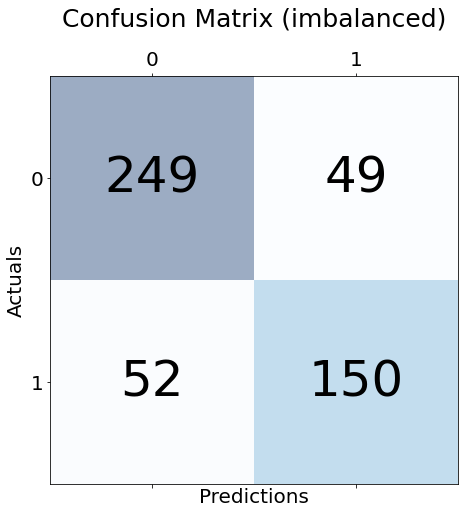

precision is 0.8272425249169435
recall is 0.8355704697986577
F1_score is 0.8313856427378965


TypeError: ignored

In [ ]:
# model evaluation
# cv_results = grid.cv_results_
# cv_results
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
import datetime
from sklearn.metrics import recall_score

y_true = y.tolist()
best_model = XGBClassifier(max_depth = 3, min_child_weight = 0.2, learning_rate = 0.1,
                           scale_pos_weight= 0.7, seed = 1)
y_pred = cross_val_predict(best_model, X, y, cv = 5)

cm = confusion_matrix(y_true, y_pred)

# cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# cm_disp.plot()
# plt.show()

conf_matrix = cm
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.4)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large', fontsize=50)
 
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Actuals', fontsize=20)
plt.title('Confusion Matrix (imbalanced)', fontsize=25, pad=30)
plt.tick_params(axis='both',  labelsize=20)
plt.show()

precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
F1_score = 2 * precision * recall / (precision + recall)
print(f"precision is {precision}")
print(f"recall is {recall}")
print(f"F1_score is {F1_score}")


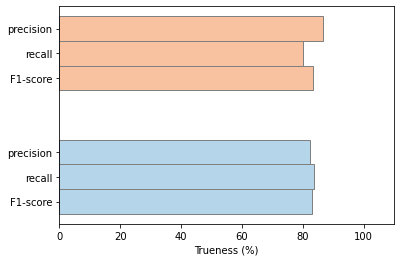

In [ ]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# width of the bars
barWidth = 0.2
 
# Choose the height of the blue bars
bars3 = [82.27, 86.59, ]
 
# Choose the height of the cyan bars
bars2 = [ 83.56, 80.20,]

bars1 = [ 83.14, 83.28,]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create blue bars
plt.barh(r1, bars1, height = barWidth, color = ['#b4d5ea', '#f8c19f'], edgecolor = 'grey',  capsize=7, label='poacee')
plt.barh(r2, bars2, height = barWidth, color = ['#b4d5ea', '#f8c19f'], edgecolor = 'grey',  capsize=7, label='sorgho')
plt.barh(r3, bars3, height = barWidth, color = ['#b4d5ea', '#f8c19f'], edgecolor = 'grey',  capsize=7, label='sorgho')

plt.xlim(0,110)

# # general layout
plt.yticks([0, 0.2, 0.4, 1, 1.2, 1.4], ['F1-score', 'recall',  'precision', 'F1-score',  'recall', 'precision'])

plt.xlabel('Trueness (%)')
# plt.legend()
 
# Show graphic
plt.show()


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00976154, 0.028131364, 0.030422894, 0.034400728, 0.03474904, 0.036087483, 0.04106068, 0.04167679, 0.0421424, 0.049796008, 0.05291487, 0.053729407, 0.062003713, 0.08370511, 0.08410765, 0.10183917, 0.21347114]
['gender', 'is_hometab', 'is_searchdiscoverscreen', 'is_portfoliogrowthscreen', 'is_employed', 'is_professional', 'investment_experience', 'is_pendingwithdrawalslistwidget', 'is_stockchartscreen', 'is_entrepreneur', 'likely_incentivised', 'num_sell', 'portfolio_beta', 'age', 'num_buy', 'days_accessed', 'purchased_hot', 'events_per_day', 'deposit_freq', 'market_timing', 'early_users', 'portfolio_performance', 'max_stock_weightage', 'holding_period']


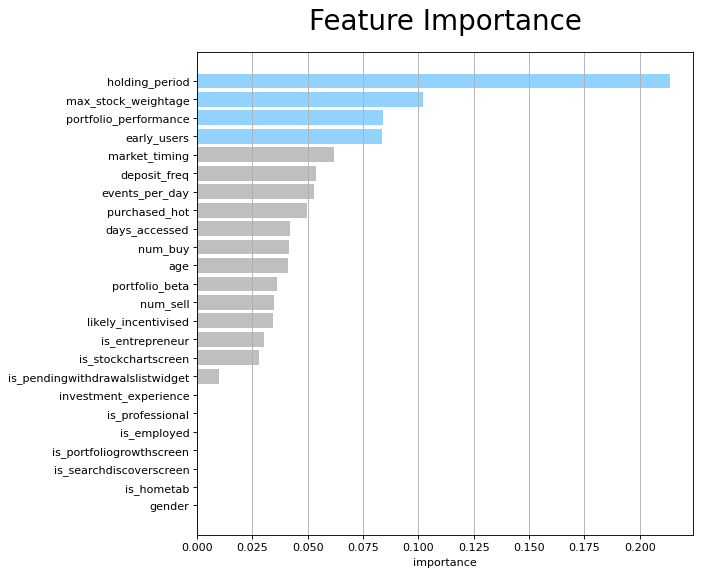

In [ ]:
# code for getting feature importance

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np

best_model.fit(X, y)
performance = best_model.feature_importances_

print()
objects = X.columns.tolist()
y_pos = np.arange(len(objects))
performance = feature_imp

mydict = {}
for i in range(len(performance)):
  mydict.update({objects[i]: performance[i]})

mydict_sorted = {k: v for k, v in sorted(mydict.items(), key=lambda item: item[1])}
# print(mydict_sorted)

performance1 = []
objects1 = []
for (a, b) in mydict_sorted.items():
  performance1.append(b)
  objects1.append(a)

print(performance1)
print(objects1)
# '#b4d5ea', '##ffe8e8e8'

figure(figsize=(8, 8), dpi=80)
color_list =  ["#bfbfbf"] * 20 + ["#91d2ff"] * 4
plt.barh(y_pos, performance1, align='center', color = color_list )
plt.yticks(y_pos, objects1)
# plt.xticks(rotation = 270)
plt.xlabel('importance')
plt.grid(True, axis="x")
plt.title('Feature Importance', fontsize = 25, pad = 20)
plt.show()

In [ ]:
# code for A/B test

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

master_df = pd.read_csv("/content/master_table.csv")
master_df = master_df.dropna(axis = 1, how = "all")

X = master_df.iloc[:,1:-1].dropna(axis = 1, how = "all")
y = master_df.iloc[:,-1]

best_model = XGBClassifier(max_depth = 3, min_child_weight = 0.2, learning_rate = 0.1, scale_pos_weight= 0.7, seed = 1)


best_model.fit(X, y)


y1 = best_model.predict(X)
print(f"sum of churns in actual: {y1.sum()} total sample is {len(y1)}   {y1.sum() / len(y1)}" )



X_test = X
X_test["holding_period"] = X_test["holding_period"] / 4
y2 = best_model.predict(X_test)

print(f"sum of churns in prediction: {y2.sum()} total sample is {len(y2)}   {y2.sum() / len(y2)}" )

# X_test = X
# X_test["holding_period"] = X_test["holding_period"] / 2
# X_test["portfolio_performance"] = X_test["portfolio_performance"] 

# y2 = best_model.predict(X_test)

# print("holding_period / 2")
# print(f"in actual, {y1.sum()} customers will churn")
# print(f"in prediction, {y2.sum()} customers will churn")



sum of churns in actual: 204 total sample is 500   0.408
sum of churns in prediction: 170 total sample is 500   0.34


In [ ]:
def get_churn_status_change():
    df_out = pd.DataFrame()

    for i in range(1,501):
        df = CHURN_STATUS_TAB[CHURN_STATUS_TAB["identifier"] == i]
        if df["is_churn"].nunique() == 2:

            df1 = df[df["is_churn"] == 1]
            # max1 = df1["churn_status_tracked_at"].max()
            min1 = df1["churn_status_tracked_at"].min()

            df0 = df[df["is_churn"] == 0]
            max0 = df0["churn_status_tracked_at"].max()
            # min0 = df0["churn_status_tracked_at"].min()

            if max0 < min1:
                df_out.loc[i, "identifier"] = i
                df_out.loc[i, "churn_from_0_to_1"] = 1

            # if max1 < min0:
            #     df_out.loc[i, "identifier"] = i
            #     df_out.loc[i, "churn_from_1_to_0"] = 1
        else:
            df_out.loc[i, "identifier"] = i
            # df_out.loc[i, "churn_from_1_to_0"] = 0
            df_out.loc[i, "churn_from_0_to_1"] = 0

    df_out["identifier"] = df_out["identifier"].astype(int)
    df_out["churn_from_0_to_1"] = df_out["churn_from_0_to_1"].astype(int)
    df_out.fillna(0, inplace = True)
    print("the number of customer who churned and hasn't came back:", df_out["churn_from_0_to_1"].sum())
    print("their identifiers are:", df_out[df_out["churn_from_0_to_1"] == 1]["identifier"].tolist())
    print()

    print("the number of cusomter who came back after getting churned:", 500 - len(df_out))
    came_back_customer = []
    for i in range(1, 501):
      if i not in df_out["identifier"].tolist():
        came_back_customer.append(i)
    print("their identifiers are:", came_back_customer)

get_churn_status_change()

the number of customer who churned and hasn't come back: 200
their identifiers are: [2, 6, 7, 10, 12, 14, 15, 20, 22, 24, 25, 27, 30, 33, 35, 36, 37, 38, 41, 43, 46, 48, 49, 50, 52, 53, 55, 57, 59, 64, 67, 68, 72, 76, 79, 80, 82, 83, 87, 89, 90, 93, 95, 97, 99, 100, 103, 104, 105, 106, 110, 114, 118, 120, 121, 122, 124, 128, 130, 131, 133, 141, 147, 152, 153, 154, 156, 157, 160, 163, 164, 170, 171, 173, 174, 176, 177, 178, 181, 184, 189, 194, 195, 199, 200, 202, 203, 204, 206, 207, 208, 212, 213, 215, 216, 219, 220, 223, 227, 229, 230, 233, 234, 235, 245, 248, 249, 250, 252, 253, 256, 258, 259, 261, 264, 266, 270, 271, 272, 274, 275, 277, 279, 282, 285, 289, 291, 293, 304, 306, 310, 313, 317, 318, 322, 323, 325, 328, 330, 331, 333, 335, 339, 343, 346, 349, 351, 352, 353, 355, 357, 358, 359, 360, 361, 362, 365, 369, 372, 373, 374, 375, 376, 377, 383, 385, 386, 387, 390, 391, 392, 398, 405, 408, 409, 410, 419, 421, 429, 430, 433, 436, 441, 442, 446, 451, 455, 458, 459, 461, 473, 479, 481

Based on the analysis above, we found that 204 out of 500 customers churned between 31 March 2022 and 2 November 2022, 200 of the churned customers hasn't came back, and only 4 of the churned cusomter came back after churned.
